# Research Questions
In this notebook, we use the scores to answer the three research questions of the bachelor thesis, namely:
* RQ1: How have BLEU scores between past SMT and modern NMT systems and LLMs changed?
* RQ2: Given 110 scores in various metrics, how do they correlate with each other?
* RQ3: Given different corpus types, are there differences in translation quality in terms of scores?

## RQ1: Machine Translation Evaluation

INTO


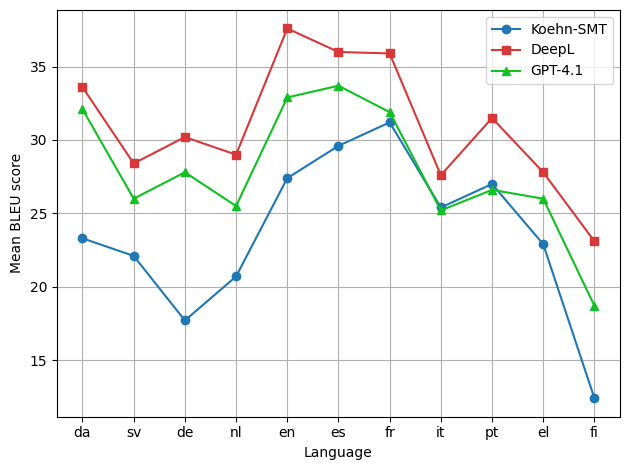

---
FROM


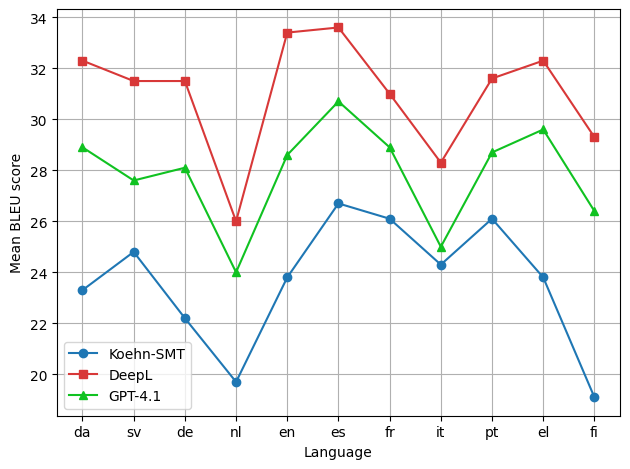

---
DIFF


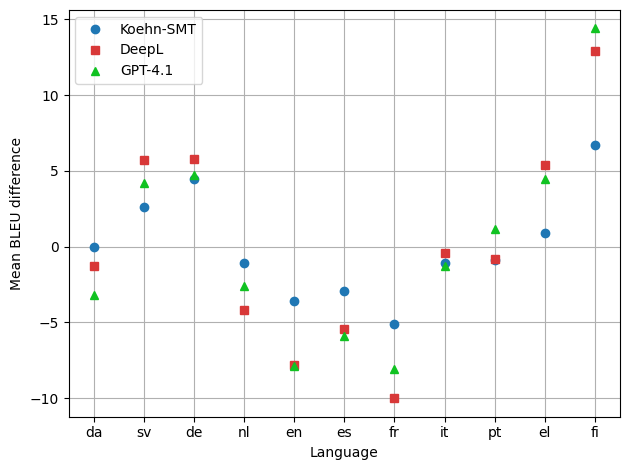

---


In [58]:
from scripts.presentation import Presenter
p = Presenter(results_folder='final_results')
interest = {}
labels = {'koehn': 'Koehn-SMT', 'deepl': 'DeepL', 'gpt': 'GPT-4.1'}
for m in ['INTO', 'FROM', 'DIFF']:
    print(m)
    if m == 'INTO' or m == 'FROM':
        ylabel = 'Mean BLEU score'
    else:
        ylabel = 'Mean BLEU difference'
    out = p.mean_metric_from_or_into_lang(mode=m, metric='BLEU', title=None, focus=['ep-gpt', 'ep-deepl'], ylabel=ylabel, label_map=labels, merge='TRANSLATOR')
    interest[m] = out
    print('---')



In [ ]:
df = interest['DIFF']
df = df[['koehn', 'deepl', 'gpt']]

for k in df:
   mean = df[k].mean()
   std = df[k].std()
   outliers = df[k][(df[k] - mean).abs() > std]
   high_outliers = outliers[outliers > mean].index.tolist()
   low_outliers = outliers[outliers < mean].index.tolist()

   print(f'{k}: {mean:.2f} ({std:.2f})')
   print(f'High Outliers: {high_outliers}')
   print(f'Low Outliers: {low_outliers}')
   print('---')

koehn: 0.00 (3.51)
High Outliers: ['de', 'fi']
Low Outliers: ['en', 'fr']
---
ep-deepl: -0.01 (3.60)
High Outliers: ['el', 'fi']
Low Outliers: ['en', 'fr']
---
ep-gpt: -0.00 (3.58)
High Outliers: ['el', 'fi']
Low Outliers: ['en']
---


In [12]:
df

,koehn,ep-deepl,ep-gpt
lang,,,
da,0.0,-1.3,-3.2
sv,2.6,3.1,1.6
de,4.5,1.3,0.2
nl,-1.1,-3.1,-1.5
en,-3.6,-4.2,-4.3
es,-2.9,-2.5,-3.0
fr,-5.1,-4.9,-3.0
it,-1.1,0.7,-0.2
pt,-0.9,0.1,2.1


* Visualizing the aggregated BLEU scores based on Table 3 in Koehn's Europarl SMT paper reveals that the general pattern, that is, if for one language Koehn has lower BLEU scores compared to other languages, then that is more or less the case for DeepL and GPT4.1 as well if we only look at the EuroParl translations. The FLORES+ translation show a drastically different pattern and it is questionable if we should use it when comparing with Koehn's results.
* However, we also observe that DeepL, at least on EuroParl text, has consistently higher BLEU scores than GPT4.1. We can show this numerically by taking the mean difference (increase) of DeepL's BLEU scores compared to Koehn against the mean difference (increase) of the GPT4.1 BLEU scores compared to Koehn. This holds true for both translatin from and into languages

In [39]:
deepl_ep_diff = interest['FROM']['ep-deepl'].mean()
gpt_ep_diff = interest['FROM']['ep-gpt'].mean()
print(f'Deepl-Ep: +{deepl_ep_diff:.2f}, GPT-Ep: +{gpt_ep_diff:.2f}')

Deepl-Ep: +7.35, GPT-Ep: +4.24


In [40]:
deepl_ep_diff = interest['INTO']['ep-deepl'].mean()
gpt_ep_diff = interest['INTO']['ep-gpt'].mean()
print(f'Deepl-Ep: +{deepl_ep_diff:.2f}, GPT-Ep: +{gpt_ep_diff:.2f}')

Deepl-Ep: +7.36, GPT-Ep: +4.25


* We also observe some critical points for GPT4.1. The mean BLEU scores for translating into languages Italian, French and Portugese are not too far away from Koehn's. Although we see negative differences, we would argue that it is too small to boldly claim it is worse. However, the fact that it is not too far away is concerning. 

In [41]:
interest['INTO']['ep-gpt'].loc[['it', 'fr', 'pt']]


lang
it   -0.2
fr    0.7
pt   -0.4
Name: ep-gpt, dtype: float64

It also does not necessarily mean that GPT4.1 is inferior as we can look at the FLORES+ BLEU scores and observe that the difference between GPT4.1 and DeepL is lower.

In [42]:
tl_ep_from_diff = interest['FROM']['ep-deepl'] - interest['FROM']['ep-gpt']
tl_ep_into_diff = interest['INTO']['ep-deepl'] - interest['INTO']['ep-gpt']

print(f'{tl_ep_from_diff.mean():.2f}', f'{tl_ep_into_diff.mean():.2f}')

3.12 3.12


In [43]:
tl_flores_from_diff = interest['FROM']['flores-deepl'] - interest['FROM']['flores-gpt']
tl_flores_into_diff = interest['INTO']['flores-deepl'] - interest['INTO']['flores-gpt']

print(f'{tl_flores_from_diff.mean():.2f}', f'{tl_flores_into_diff.mean():.2f}')

0.27 0.28


* So overall we can state the following:
* BLEU scores have improved since Koehn's paper and seem to follow a similar general pattern that was present back then as well; languages directions that had high BLEU scores then, seem to have high BLEU scores today as well and vice versa. More specifically:
    *  Translating into Finnish and from Dutch remains the hardest task for all translation system given that EuroParl text is used. 
    * Exceptions in Koehn's pattern occur when translating from and into Danish German and English, with mean BLEU scores being higher than Koehn's compared to the other languages.


koehn


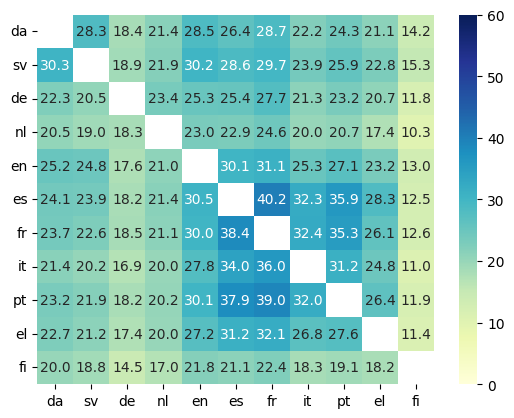


ep


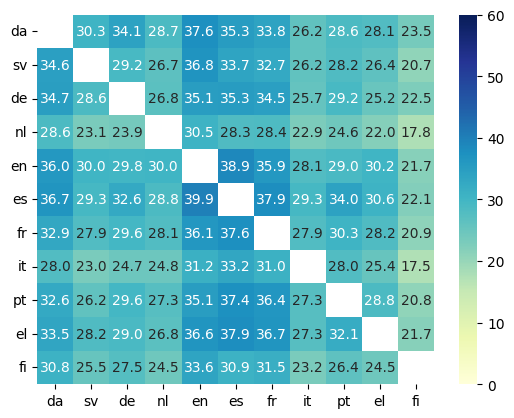

In [44]:
p.show_score_matrices(with_koehn=True, focus=['ep-gpt', 'ep-deepl'], merge='DATASET')


* We can make a similar observation if we plot all BLEU scores as a heatmap; we observe that the general color pattern present in Koehn's BLEU score matrix persisted in our results as well.
* However, we cannot say for certain if these scores reflect the true state of translation quality, as we observe strong differences in patterns when we look at FLORES+

## RQ2: Beyond BLEU Scores
* Since we obtained 110 translations for two datasets and two translators, we can afford to play around with the correlations of various translation metrics

In [45]:
from scripts.presentation import Presenter
from collections import Counter
top_4_outliers = Counter()
p = Presenter(results_folder='final_results', metrics=['COMET', 'BLEU', 'chrF', 'BERT-F1'])

for t in p.translators:
    for d in p.datasets:
        if d == 'opus':
            continue
        key = f'{d}-{t}'
        config1 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'BLEU'
        }
        config2 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'chrF'
        }
        
        config3 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'COMET'
        }
        
        config4 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'BERT-F1'
        }
        p.show_correlations(config1, config2)
        p.show_correlations(config1, config3)
        p.show_correlations(config1, config4)

Datasets: ['ep'] : ['ep']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : chrF
Pearson correlation: 0.88 (p = 4.1e-36)
Spearman correlation: 0.89 (p = 2.6e-39)

Datasets: ['ep'] : ['ep']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : COMET
Pearson correlation: -0.27 (p = 4.1e-03)
Spearman correlation: -0.18 (p = 6.4e-02)

Datasets: ['ep'] : ['ep']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : BERT-F1
Pearson correlation: 0.89 (p = 1.5e-39)
Spearman correlation: 0.91 (p = 6.1e-44)

Datasets: ['flores'] : ['flores']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : chrF
Pearson correlation: 0.95 (p = 7.5e-55)
Spearman correlation: 0.93 (p = 4.7e-49)

Datasets: ['flores'] : ['flores']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : COMET
Pearson correlation: 0.29 (p = 2.2e-03)
Spearman correlation: 0.25 (p = 8.7e-03)

Datasets: ['flores'] : ['flores']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : BERT-F1
Pearson correlation: 0.97 (p = 1.3e-67)
Spearman correlation: 0.96 (p = 2.7e-60)

Datasets: ['

* Simple correlation coefficients alone tell us a very interesting story. While BLEU and chrF have a strong positive correlation, BLEU and COMET have a weak negative correlation for EuroParl and a weak positive correlation for FLORES+, whereas the Spearman correlation for GPT4.1 for FLORES+ is not statistically significant anymore. I.e., we can say for certain that BLEU and COMET are not correlating too strongly overall.
* We now can start an investigation by inspecting the case EuroParl - DeepL, it has the lowest correlation compared to all other BLEU/chrF cases.

Datasets: ['ep'] : ['ep']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : chrF
Pearson correlation: 0.84 (p = 8.8e-31)
Spearman correlation: 0.84 (p = 4.6e-31)

Outliears:  [('tgt-fi', 8), ('tgt-el', 6), ('src-nl', 4), ('src-fr', 3)]


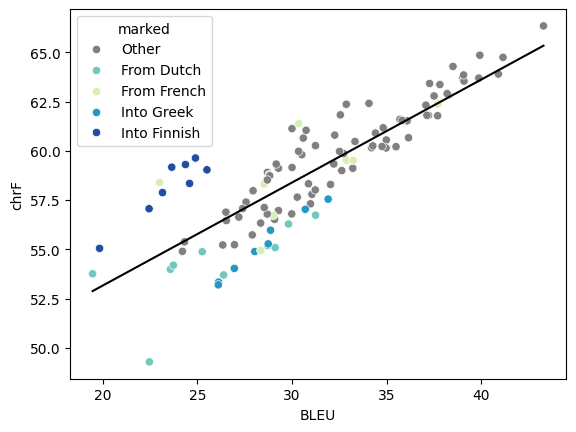

In [46]:
config1 = {
    'datasets': ['ep'],
    'translators': ['deepl'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'BLEU'
}
config2 = {
    'datasets': ['ep'],
    'translators': ['deepl'],
    'src_lang': None,
    'tgt_lang': None,
    'metric': 'chrF'
}
p.show_correlations(config1, config2)
out, model = p.linear_regression(config1, config2, 'BLEU', 'chrF', plot=False)
outliers = p.top_n_residuals(out, model, top_n=20)
custom_col, top = p.colors_src_tgt_residual_freq(outliers, n=4)
print('Outliears: ', top)
out, model = p.linear_regression(config1, config2, 'BLEU', 'chrF', custom_color=custom_col)
top_4_outliers.update([o[0] for o in top])

In [47]:
outliers = p.top_n_residuals(out, model, top_n=20)
print(outliers['src_lang'].value_counts())
print(outliers['tgt_lang'].value_counts())

src_lang
nl    4
fr    3
el    2
es    2
de    2
sv    2
en    1
fi    1
pt    1
it    1
da    1
Name: count, dtype: int64
tgt_lang
fi    8
el    6
de    3
es    1
pt    1
da    1
Name: count, dtype: int64


* Using linear regression, we see the expected increasing line that represents the positive correlation between chrF and BLEU. If we inspect the outliers, we observe that into Finnish and Greek translations tend to occur frequently. We can mark these specific pairs in the visualization as well.
* This means that BLEU and chrF disagree the most for whenever Finnish and Greek are target languages

Datasets: ['ep'] : ['ep']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : chrF
Pearson correlation: 0.88 (p = 4.1e-36)
Spearman correlation: 0.89 (p = 2.6e-39)

Outliears:  [('tgt-el', 7), ('tgt-fi', 6), ('tgt-de', 4), ('src-nl', 3)]


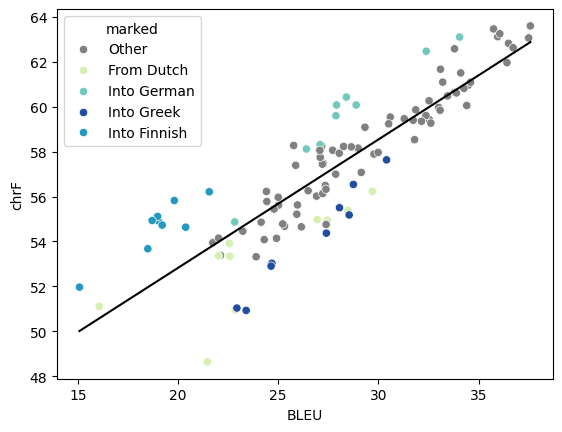

Datasets: ['flores'] : ['flores']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : chrF
Pearson correlation: 0.94 (p = 6.1e-53)
Spearman correlation: 0.92 (p = 5.4e-47)

Outliears:  [('tgt-fi', 10), ('tgt-el', 7), ('src-sv', 3), ('src-nl', 3)]


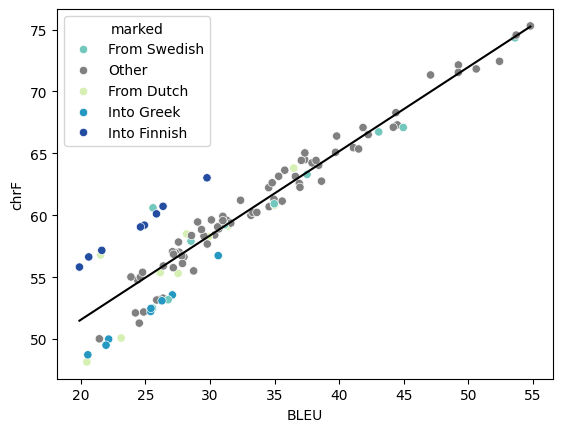

Datasets: ['flores'] : ['flores']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : chrF
Pearson correlation: 0.95 (p = 7.5e-55)
Spearman correlation: 0.93 (p = 4.7e-49)

Outliears:  [('tgt-fi', 10), ('tgt-el', 9), ('src-nl', 3), ('src-sv', 2)]


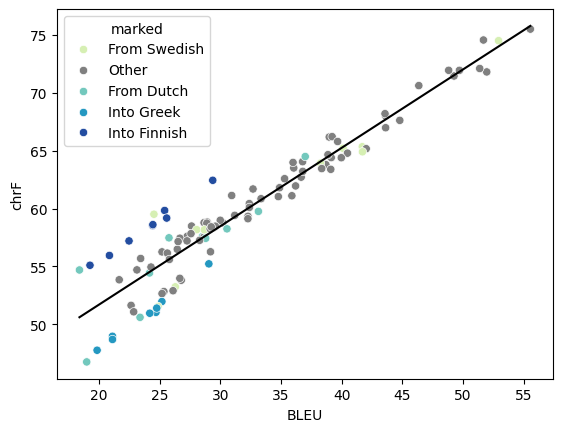

In [48]:
for d in ['ep', 'flores']:
    for t in ['deepl', 'gpt']:
        if d == 'ep' and t == 'deepl':
            continue
        config1 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'BLEU'

        }
        config2 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'chrF'
        }

        p.show_correlations(config1, config2)
        out, model = p.linear_regression(
            config1, config2, 'BLEU', 'chrF', plot=False)
        outliers = p.top_n_residuals(out, model, top_n=20)
        custom_col, top = p.colors_src_tgt_residual_freq(outliers)
        print('Outliears: ', top)
        out, model = p.linear_regression(
            config1, config2, 'BLEU', 'chrF', custom_color=custom_col)
        top_4_outliers.update([o[0] for o in top])

Datasets: ['ep'] : ['ep']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : COMET
Pearson correlation: -0.31 (p = 9.4e-04)
Spearman correlation: -0.26 (p = 6.9e-03)

Outliears:  [('tgt-fi', 7), ('src-nl', 6), ('src-en', 4), ('tgt-da', 3)]


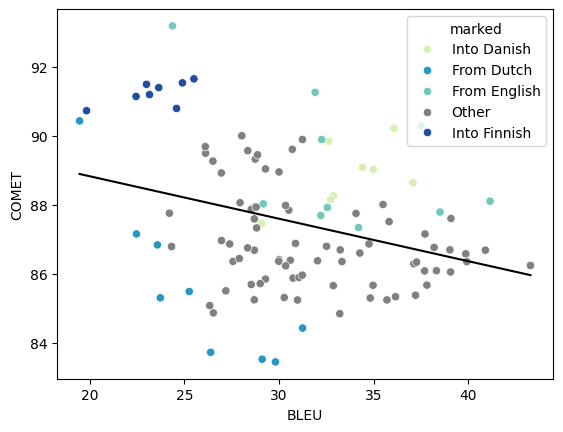

Datasets: ['ep'] : ['ep']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : COMET
Pearson correlation: -0.27 (p = 4.1e-03)
Spearman correlation: -0.18 (p = 6.4e-02)

Outliears:  [('tgt-fi', 5), ('src-nl', 4), ('src-en', 3), ('src-it', 3)]


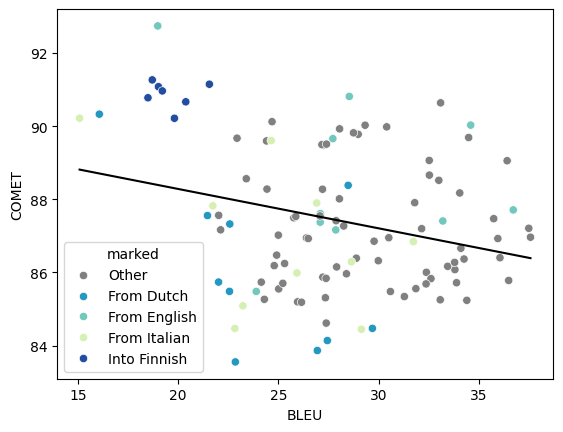

Datasets: ['flores'] : ['flores']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : COMET
Pearson correlation: 0.29 (p = 2.4e-03)
Spearman correlation: 0.26 (p = 6.9e-03)

Outliears:  [('tgt-fi', 10), ('src-nl', 4), ('src-el', 4), ('tgt-es', 4)]


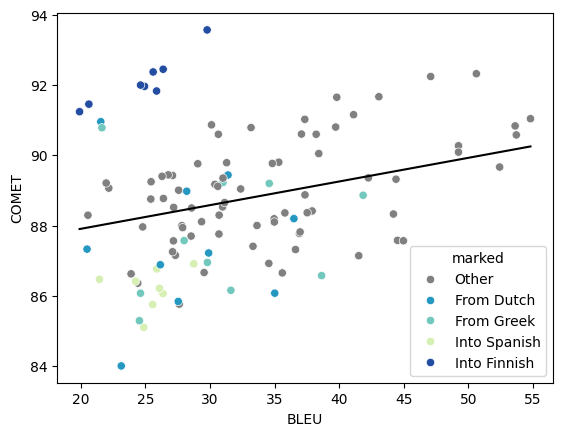

Datasets: ['flores'] : ['flores']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : COMET
Pearson correlation: 0.29 (p = 2.2e-03)
Spearman correlation: 0.25 (p = 8.7e-03)

Outliears:  [('tgt-fi', 10), ('tgt-es', 6), ('src-nl', 3), ('src-es', 3)]


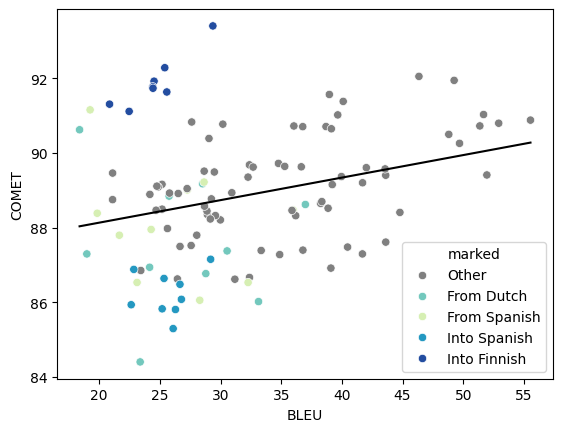

In [49]:
for d in ['ep', 'flores']:
    for t in ['deepl', 'gpt']:
        config1 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'BLEU'

        }
        config2 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'COMET'
        }
        p.show_correlations(config1, config2)
        out, model = p.linear_regression(config1, config2, 'BLEU', 'COMET', plot=False)
        outliers = p.top_n_residuals(out, model, top_n=20)
        custom_col, top = p.colors_src_tgt_residual_freq(outliers)
        print('Outliears: ', top)
        out, model = p.linear_regression(config1, config2, 'BLEU', 'COMET', custom_color=custom_col)
        top_4_outliers.update([o[0] for o in top])

* If we visualize the weak negative relation using linear regression for BLEU and COMET and mark into Finnish and Greek translations once again, we observe that into Finnish translations have actually very high COMET scores despite low BLEU scores, something similar is the case for Greek.
* This leads to the conclusion that perhaps, into Finnish translations are not lower quality despite low BLEU scores, both COMET and chrF tell a different story.
* As for why chrF is low for Greek, that is likely related to the fact that Greek uses accented characters, which may not be handled well by chrF. 
* Overall, these correlations tell us that we should not overly rely on BLEU and treat translation evaluation from a more nuanced perspectives. We can also argue that perhaps for some languages, BLEU makes more sense, for others less. 

Datasets: ['ep'] : ['ep']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : BERT-F1
Pearson correlation: 0.93 (p = 1.2e-49)
Spearman correlation: 0.93 (p = 8.8e-49)

Outliears:  [('tgt-fi', 7), ('tgt-nl', 5), ('src-it', 4), ('src-el', 2)]


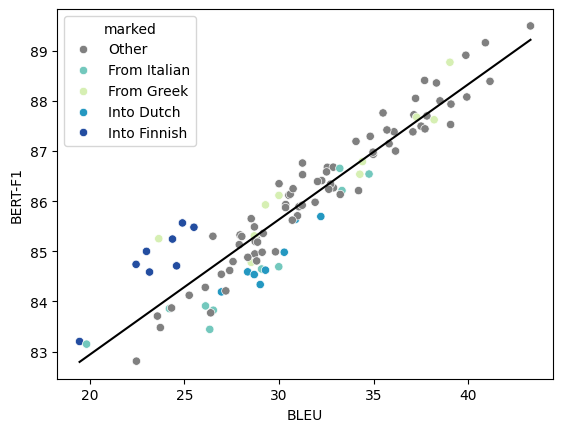

Datasets: ['ep'] : ['ep']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : BERT-F1
Pearson correlation: 0.89 (p = 1.5e-39)
Spearman correlation: 0.91 (p = 6.1e-44)

Outliears:  [('tgt-fi', 5), ('tgt-en', 5), ('src-de', 4), ('tgt-nl', 4)]


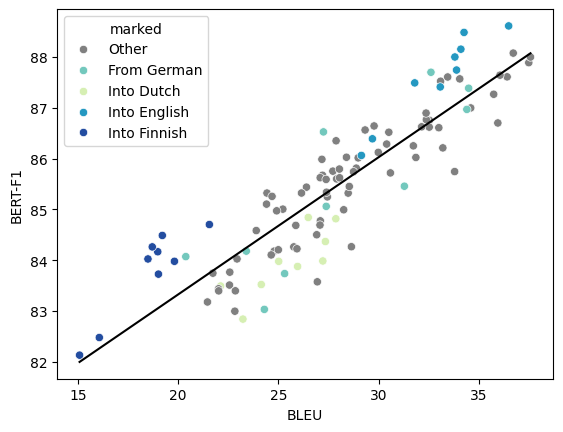

Datasets: ['flores'] : ['flores']
Translators: ['deepl'] : ['deepl']
Metric: BLEU : BERT-F1
Pearson correlation: 0.96 (p = 2.2e-60)
Spearman correlation: 0.94 (p = 2.9e-53)

Outliears:  [('tgt-pt', 8), ('tgt-el', 4), ('src-en', 3), ('src-es', 3)]


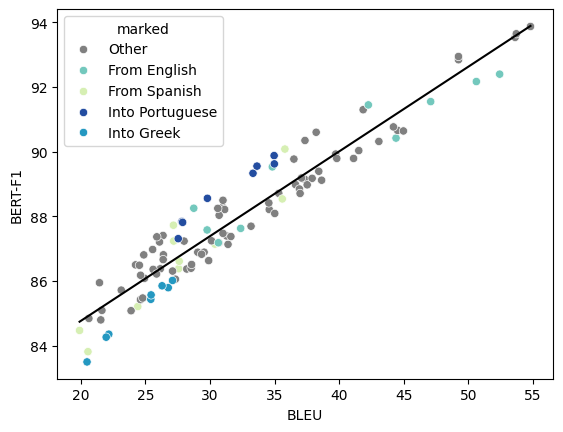

Datasets: ['flores'] : ['flores']
Translators: ['gpt'] : ['gpt']
Metric: BLEU : BERT-F1
Pearson correlation: 0.97 (p = 1.3e-67)
Spearman correlation: 0.96 (p = 2.7e-60)

Outliears:  [('tgt-el', 7), ('tgt-es', 4), ('src-en', 3), ('src-es', 3)]


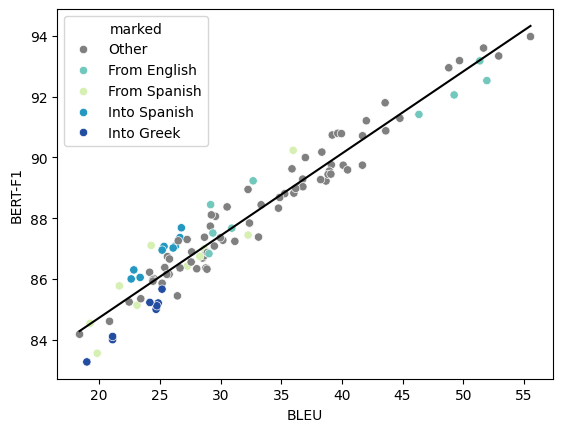

In [50]:
for d in ['ep', 'flores']:
    for t in ['deepl', 'gpt']:
        config1 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'BLEU'

        }
        config2 = {
            'datasets': [d],
            'translators': [t],
            'src_lang': None,
            'tgt_lang': None,
            'metric': 'BERT-F1'
        }
        p.show_correlations(config1, config2)
        out, model = p.linear_regression(config1, config2, 'BLEU', 'BERT-F1', plot=False)
        outliers = p.top_n_residuals(out, model, top_n=20)
        custom_col, top = p.colors_src_tgt_residual_freq(outliers)
        print('Outliears: ', top)
        out, model = p.linear_regression(config1, config2, 'BLEU', 'BERT-F1', custom_color=custom_col)
        top_4_outliers.update([o[0] for o in top])

* Correlation with BERT-F1 reveal a disagreement between BLEU and BERT-F1 for Into Finnish translations, specifically for EuroParl

In [51]:
print('Top 4 Outliers:')
for k, v in sorted(top_4_outliers.items(), key=lambda x: x[1], reverse=True):
    print(f'{k}: {v}')

Top 4 Outliers:
tgt-fi: 10
src-nl: 8
tgt-el: 6
src-en: 4
tgt-es: 3
src-es: 3
src-sv: 2
src-it: 2
src-el: 2
tgt-nl: 2
src-fr: 1
tgt-de: 1
tgt-da: 1
tgt-en: 1
src-de: 1
tgt-pt: 1


In [52]:
# Show matrices
# p.show_score_matrices(metric='chrF', vmin=45, vmax=75)
# p.show_score_matrices(metric='COMET', vmin=80, vmax=95)
# p.show_score_matrices(metric='BERT-F1', vmin=80, vmax=95)

## RQ3: Dimensional Differences
* Since we worked with 3 different datasets, it would be interesting to see differences in translation quality between them.
* OPUS100 was only computed on 20 pairs, so we can compare them against their direct BLEU scores

### Metric From/Into English
* Real BLEU scores; focus on particular rows/columns (into/from English)

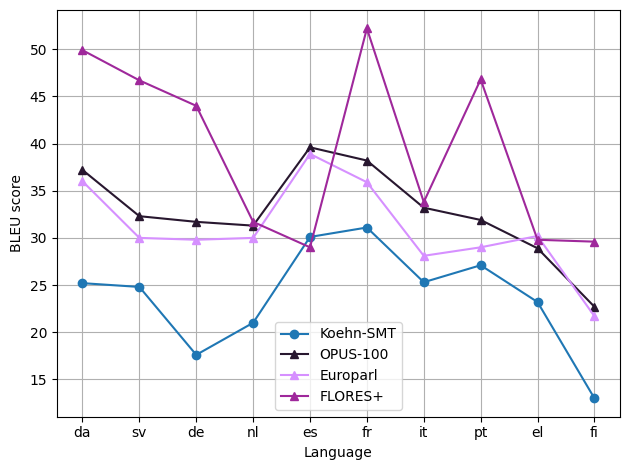

BLEU
FROM
ep minus opus: -1.74
ep minus flores: -8.39
---


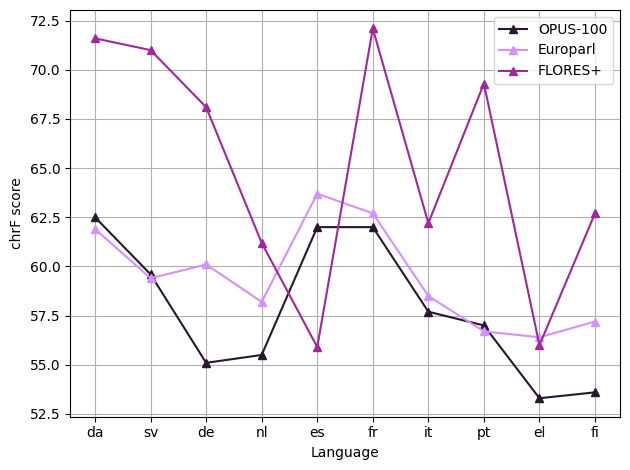

chrF
FROM
ep minus opus: 1.65
ep minus flores: -5.53
---


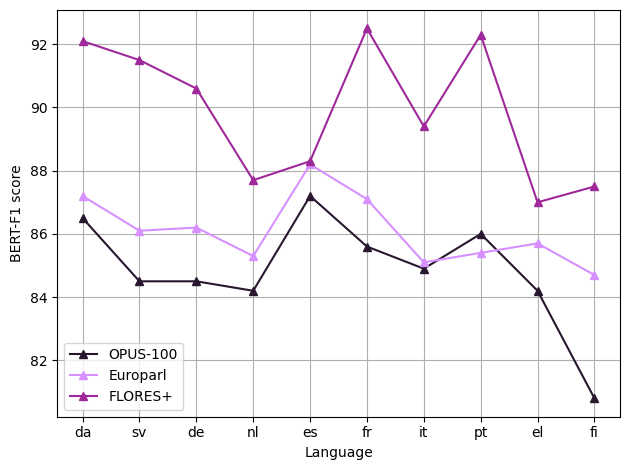

BERT-F1
FROM
ep minus opus: 1.26
ep minus flores: -3.79
---


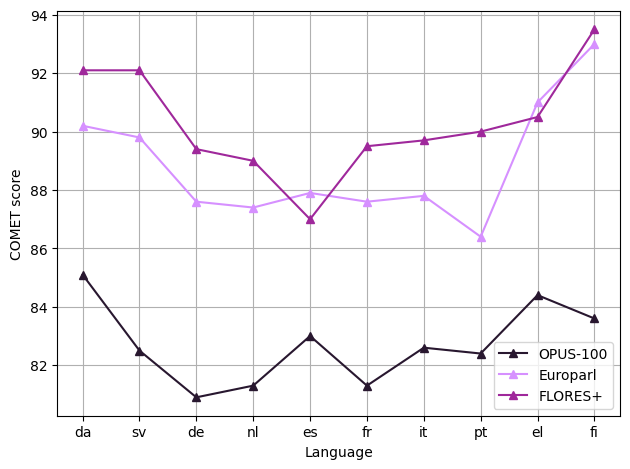

COMET
FROM
ep minus opus: 6.16
ep minus flores: -1.41
---


In [79]:
from scripts.presentation import Presenter
p = Presenter(results_folder='final_results',
              metrics=['BLEU', 'chrF', 'COMET', 'BERT-F1'])


def print_diff(out, mode):
    diff1 = out['ep'] - out['opus']
    diff2 = out['ep'] - out['flores']
    print(f'{mode}')
    print(f'ep minus opus: {diff1.mean():.2f}')
    print(f'ep minus flores: {diff2.mean():.2f}')

labels = {'koehn': 'Koehn-SMT', 'ep': 'Europarl', 'flores': 'FLORES+', 'opus': 'OPUS-100'}

for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    for m in ['FROM']:
        _ = p.metric_from_or_into_language(mode=m, metric=met, merge='DATASET', with_koehn=met=='BLEU', label_map=labels)
        print(met)
        print_diff(_, m)
        print('---')

In [80]:
# def print_diff(out, mode):
#     diff = out['deepl'] - out['gpt']
#     print(f'{mode}')
#     print(f'deepl minus gpt: {diff.mean():.2f}')

# labels = {'koehn': 'Koehn-SMT', 'deepl': 'DeepL', 'gpt': 'GPT-4.1'}
# for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
#     for m in ['INTO', 'FROM']:
#         _ = p.metric_from_or_into_language(
#             mode=m, metric=met, merge='TRANSLATOR', with_koehn=met=='BLEU', label_map=labels)
#         print(met)
#         print_diff(_, m)
#         print('---')

* The difference between translators decreases when switching from BLEU to chrF, BERT-F1 and COMET
* Based on these metrics, 20 data points, we can make a weak assumption that perhaps, OPUS could be used as a representative of the EuroParl dataset, whereas FLORES+ is strongly different.
* However, both EuroParl and OPUS100 contain different text types for sure. OPUS100 is more random as it contains movie subtitles, Bible texts and also faulty data here and there. EuroParl contains proceedings from the European Parliament. One may argue that subtitles and verbatim parliamentary proceedings are not too far away from each other, spoken text, whereas FLORES+ is from wiki articles, written text. 

### Mean Metric From/Into Language
* Considers aggregation over rows/columns

In [81]:
# def print_diff(out, mode):
#     diff2 = out['ep'] - out['flores']
#     print(f'{mode}')
#     print(f'ep minus flores: {diff2.mean():.2f}')



# labels = {'koehn': 'Koehn-SMT', 'ep': 'Europarl', 'flores': 'FLORES+'}
# checks = {}
# for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
#     for m in ['INTO', 'FROM']:
#         _ = p.mean_metric_from_or_into_lang(mode=m, metric=met, merge='DATASET', with_koehn=met=='BLEU', label_map=labels)
#         print(met)
#         print_diff(_, m)
#         print('---')
#         checks[f'{met}-{m}'] = _

BLEU INTO


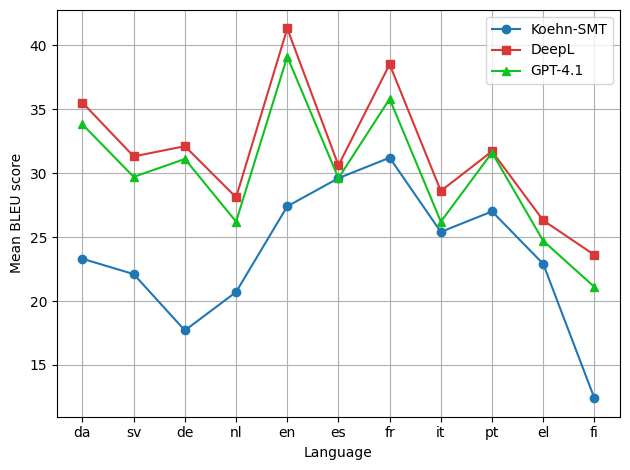

deepl minus gpt: 1.70
---
chrF INTO


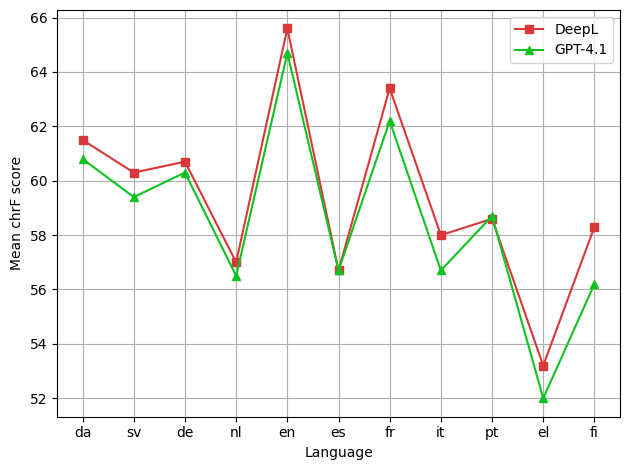

deepl minus gpt: 0.83
---
BERT-F1 INTO


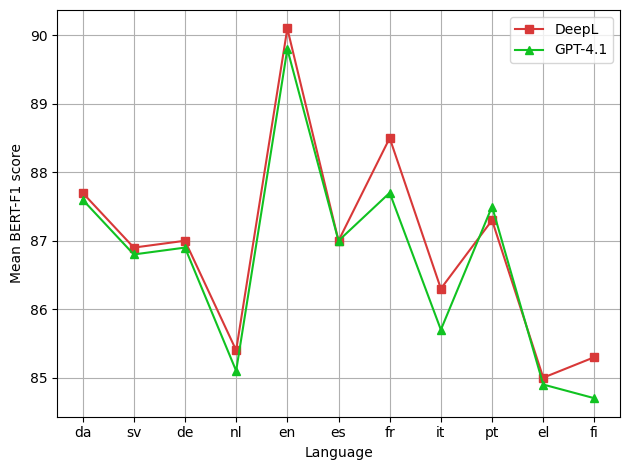

deepl minus gpt: 0.25
---
COMET INTO


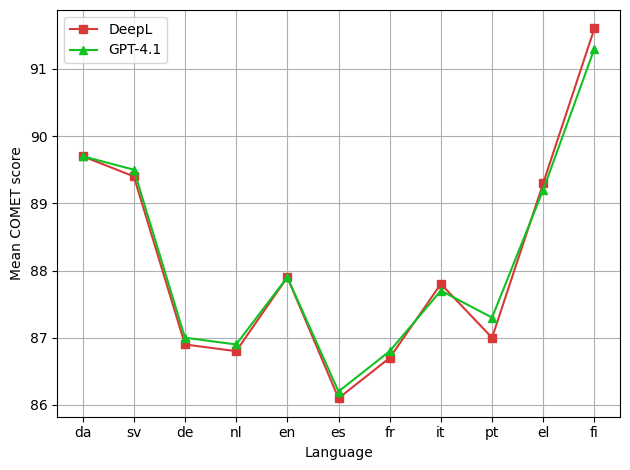

deepl minus gpt: -0.03
---


In [82]:
def print_diff(out):
    diff = out['deepl'] - out['gpt']
    print(f'deepl minus gpt: {diff.mean():.2f}')
checks = {}

interest = {}
labels = {'koehn': 'Koehn-SMT', 'deepl': 'DeepL', 'gpt': 'GPT-4.1'}
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    for m in ['INTO']:
        print(met, m)
        ylabel = f'Mean {met} score'
        _ = p.mean_metric_from_or_into_lang(
            mode=m, metric=met, merge='TRANSLATOR', with_koehn=met=='BLEU', label_map=labels, ylabel=ylabel)
        print_diff(_)
        print('---')
        checks[f'{met}-{m}'] = _
        interest[met] = p.mean_metric_from_or_into_lang(
            mode='DIFF', metric=met, merge='TRANSLATOR', with_koehn=False, plot=False)

In [75]:
for k in interest:
    for tl in ['deepl', 'gpt']:
        mean = interest[k][tl].mean()
        std = interest[k][tl].std()
        outliers = interest[k][tl][(interest[k][tl] - mean).abs() > std]
        high_outliers = outliers[outliers > mean].index.tolist()
        low_outliers = outliers[outliers < mean].index.tolist()
        print(f'{k} {tl}: {mean:.2f} ({std:.2f})')
        print(f'High Outliers: {high_outliers}')
        print(f'Low Outliers: {low_outliers}')
        print('---')

BLEU deepl: -0.01 (3.72)
High Outliers: ['el', 'fi']
Low Outliers: ['en', 'fr']
---
BLEU gpt: -0.00 (3.73)
High Outliers: ['el', 'fi']
Low Outliers: ['en', 'fr']
---
chrF deepl: -0.00 (2.79)
High Outliers: ['el']
Low Outliers: ['fr']
---
chrF gpt: -0.02 (2.92)
High Outliers: ['el']
Low Outliers: ['en', 'fr']
---
BERT-F1 deepl: 0.00 (1.09)
High Outliers: ['el', 'fi']
Low Outliers: ['en', 'fr']
---
BERT-F1 gpt: -0.01 (1.11)
High Outliers: ['el', 'fi']
Low Outliers: ['en']
---
COMET deepl: 0.01 (1.71)
High Outliers: ['en']
Low Outliers: ['fi']
---
COMET gpt: -0.01 (1.51)
High Outliers: ['en', 'es', 'fr']
Low Outliers: ['fi']
---


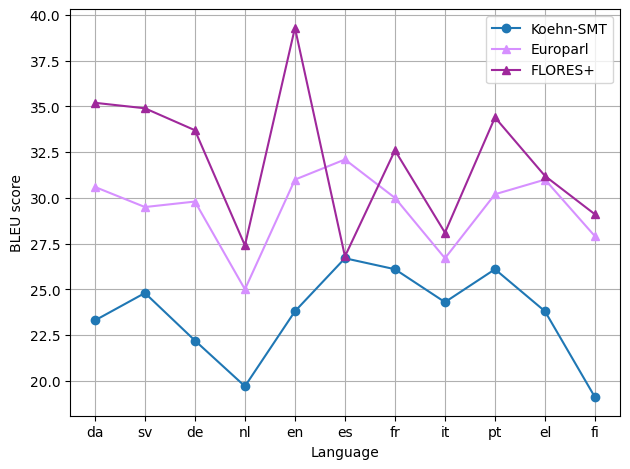

---


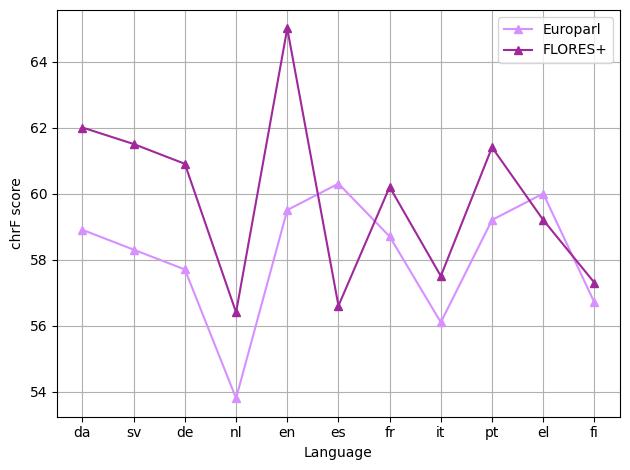

---


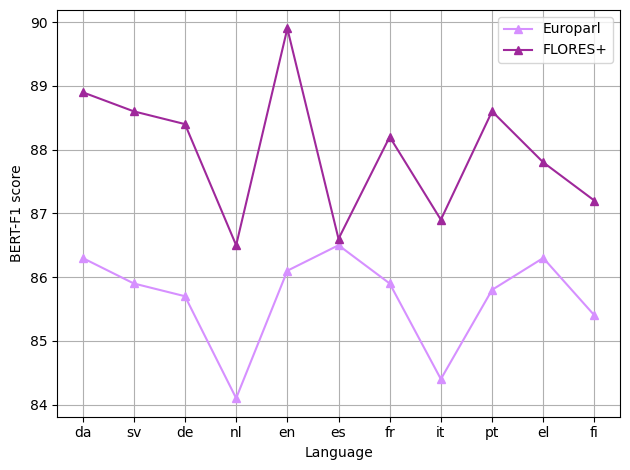

---


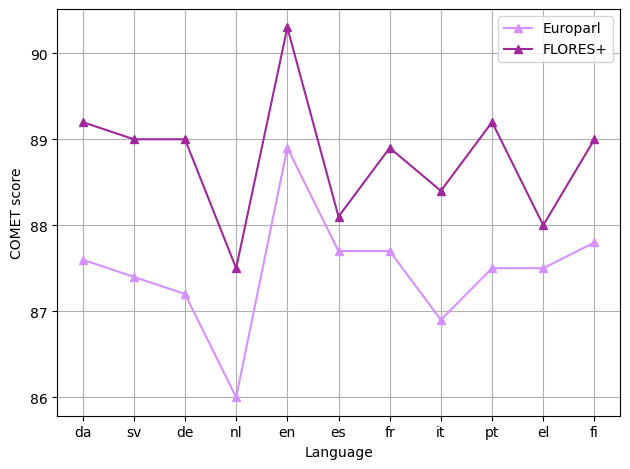

---


In [78]:
interest = {}
labels = {'koehn': 'Koehn-SMT', 'flores': 'FLORES+', 'ep': 'Europarl'}
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    for m in ['FROM']:
        _ = p.mean_metric_from_or_into_lang(
            mode=m, metric=met, merge='DATASET', with_koehn=met == 'BLEU', label_map=labels)
        print('---')
        interest[met] = p.mean_metric_from_or_into_lang(
            mode='DIFF', metric=met, merge='DATASET', with_koehn=False, plot=False)

In [73]:
for k in interest:
    for corp in ['ep', 'flores']:
        mean = interest[k][corp].mean()
        std = interest[k][corp].std()
        outliers = interest[k][corp][(interest[k][corp] - mean).abs() > std]
        high_outliers = outliers[outliers > mean].index.tolist()
        low_outliers = outliers[outliers < mean].index.tolist()
        print(f'{k} {corp}: {mean:.2f} ({std:.2f})')
        print(f'High Outliers: {high_outliers}')
        print(f'Low Outliers: {low_outliers}')
        print('---')

BLEU ep: 0.00 (3.49)
High Outliers: ['el', 'fi']
Low Outliers: ['en', 'fr']
---
BLEU flores: 0.01 (4.26)
High Outliers: ['el', 'fi']
Low Outliers: ['en', 'fr']
---
chrF ep: 0.00 (2.45)
High Outliers: ['pt', 'el']
Low Outliers: []
---
chrF flores: 0.01 (3.51)
High Outliers: ['es', 'el']
Low Outliers: ['en', 'fr']
---
BERT-F1 ep: -0.01 (0.88)
High Outliers: ['el', 'fi']
Low Outliers: ['en']
---
BERT-F1 flores: -0.01 (1.34)
High Outliers: ['el', 'fi']
Low Outliers: ['en', 'fr']
---
COMET ep: 0.01 (1.88)
High Outliers: ['en']
Low Outliers: ['el', 'fi']
---
COMET flores: 0.00 (1.46)
High Outliers: ['de', 'es']
Low Outliers: ['fi']
---


### Metric Influence on Difference for Translating FROM and INTO

In [12]:
interest = {}
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    print(met)
    _ = p.mean_metric_from_or_into_lang(
        mode='DIFF', metric=met, merge='ALL', with_koehn=False, label_map=labels, plot=False)
    interest[met] = _

BLEU
chrF
BERT-F1
COMET


In [14]:
for k in interest:
    mean = interest[k]['all'].mean()
    std = interest[k]['all'].std()
    outliers = interest[k]['all'][(interest[k]['all'] - mean).abs() > std]
    high_outliers = outliers[outliers > mean].index.tolist()
    low_outliers = outliers[outliers < mean].index.tolist()
    print(f'{k}: {mean:.2f} ({std:.2f})')
    print(f'High Outliers: {high_outliers}')
    print(f'Low Outliers: {low_outliers}')
    print('---')



BLEU: -0.01 (3.70)
High Outliers: ['el', 'fi']
Low Outliers: ['en', 'fr']
---
chrF: 0.01 (2.82)
High Outliers: ['el']
Low Outliers: ['en', 'fr']
---
BERT-F1: 0.00 (1.06)
High Outliers: ['el', 'fi']
Low Outliers: ['en']
---
COMET: -0.02 (1.59)
High Outliers: ['en', 'es']
Low Outliers: ['fi']
---


### Detecting All Outliers

In [61]:
from scripts.presentation import Presenter
p = Presenter(results_folder='final_results',
              metrics=['BLEU', 'chrF', 'COMET', 'BERT-F1'])

In [66]:
checks = {}
interest = {}
for met in ['BLEU', 'chrF', 'BERT-F1', 'COMET']:
    for m in ['INTO', 'FROM']:
        _ = p.mean_metric_from_or_into_lang(
            mode=m, metric=met, with_koehn=False, plot=False)
        checks[f'{met}|{m}'] = _
        interest[f'{met}|DIFF'] = p.mean_metric_from_or_into_lang(
            mode='DIFF', metric=met, with_koehn=False, plot=False)

In [67]:
def outliers(data_src, k1, k2):
    metric, direction = k1.split('|')
    corpus, tl = k2.split('-')
    std = data_src[k1][k2].std()
    mean = data_src[k1][k2].mean()
    outliers = data_src[k1][k2][(data_src[k1][k2] - mean).abs() > std]
    high_outliers = outliers[outliers > mean].index.tolist()
    low_outliers = outliers[outliers < mean].index.tolist()
    entry = {
        'corpus': corpus,
        'tl': tl,
        'metric' : metric,
        'direction': direction,
        'sd' : std,
        'mean': mean,
        'high_outliers': high_outliers,
        'low_outliers': low_outliers
    }
    return entry

data = []
for k in checks:
    for t in ['ep-deepl', 'ep-gpt', 'flores-deepl', 'flores-gpt']:
        entry = outliers(checks, k, t)
        data.append(entry)

In [70]:
diff_data = []
for k in interest:
    for t in ['ep-deepl', 'ep-gpt', 'flores-deepl', 'flores-gpt']:
        entry = outliers(interest, k, t)
        diff_data.append(entry)

In [71]:
import pandas as pd
df = pd.DataFrame(diff_data)
df

,corpus,tl,metric,direction,sd,mean,high_outliers,low_outliers
0,ep,deepl,BLEU,DIFF,3.601237,-9.090909e-03,"[el, fi]","[en, fr]"
1,ep,gpt,BLEU,DIFF,3.581620,-8.074349e-17,"[el, fi]",[en]
2,flores,deepl,BLEU,DIFF,4.330820,0.000000e+00,"[el, fi]","[en, fr]"
3,flores,gpt,BLEU,DIFF,4.439144,0.000000e+00,"[el, fi]","[en, fr]"
4,ep,deepl,chrF,DIFF,2.424234,9.090909e-03,[el],"[nl, fr]"
5,ep,gpt,chrF,DIFF,2.663252,-9.090909e-03,"[pt, el]",[]
6,flores,deepl,chrF,DIFF,3.512497,1.818182e-02,"[es, el]","[en, fr]"
7,flores,gpt,chrF,DIFF,3.699189,-3.027881e-17,[el],"[en, fr]"
8,ep,deepl,BERT-F1,DIFF,0.932153,-9.090909e-03,[el],"[en, fr]"
9,ep,gpt,BERT-F1,DIFF,0.959640,-9.090909e-03,"[el, fi]",[en]


In [24]:
import pandas as pd
df = pd.DataFrame(data)
df = df[(df['high_outliers'].apply(len) > 0) | (df['low_outliers'].apply(len) > 0) ]
# print(df.to_latex(float_format='%.2f', index=False))


In [25]:
for met in ['BLEU', 'chrF', 'COMET', 'BERT-F1']:
    for corp in ['ep', 'flores']:
        df_x = df[(df['corpus'] == corp) & (df['metric'] == met)]
        mean = df_x['mean'].mean()
        print(f'{met}-{corp}: {mean:.2f}')



BLEU-ep: 29.42
BLEU-flores: 32.08
chrF-ep: 58.11
chrF-flores: 59.83
COMET-ep: 87.45
COMET-flores: 88.79
BERT-F1-ep: 85.67
BERT-F1-flores: 87.96


In [26]:
for met in ['BLEU', 'chrF', 'COMET', 'BERT-F1']:
    for tl in ['deepl', 'gpt']:
        df_x = df[(df['tl'] == tl) & (df['metric'] == met)]
        mean = df_x['mean'].mean()
        print(f'{met}-{tl}: {mean:.2f}')

BLEU-deepl: 31.60
BLEU-gpt: 29.90
chrF-deepl: 59.39
chrF-gpt: 58.55
COMET-deepl: 88.10
COMET-gpt: 88.15
BERT-F1-deepl: 86.93
BERT-F1-gpt: 86.70


In [27]:
from collections import Counter
high_counter = Counter(
    lang for sublist in df['high_outliers'] for lang in sublist)

low_counter = Counter(
    lang for sublist in df['low_outliers'] for lang in sublist)

In [28]:
high_counter, low_counter

(Counter({'en': 23, 'es': 11, 'fr': 6, 'fi': 4, 'el': 3}),
 Counter({'nl': 18, 'es': 12, 'fi': 9, 'el': 9, 'it': 9}))

In [29]:
df1 = df[df['direction'] == 'INTO']
df1

,corpus,tl,metric,direction,sd,mean,high_outliers,low_outliers
0,ep,deepl,BLEU,INTO,4.417939,30.972727,"[en, es, fr]",[fi]
1,ep,gpt,BLEU,INTO,4.459454,27.854545,"[en, es]",[fi]
2,flores,deepl,BLEU,INTO,6.945188,32.218182,"[en, fr]","[es, el, fi]"
3,flores,gpt,BLEU,INTO,7.207950,31.936364,"[en, fr]","[el, fi]"
8,ep,deepl,chrF,INTO,2.270442,58.909091,"[en, fr]",[el]
9,ep,gpt,chrF,INTO,2.535924,57.309091,"[es, fr]","[el, fi]"
10,flores,deepl,chrF,INTO,5.153075,59.872727,[en],"[es, el]"
11,flores,gpt,chrF,INTO,5.362733,59.790909,[en],"[es, el]"
16,ep,deepl,BERT-F1,INTO,1.180216,85.890909,"[en, es, fr]","[nl, fi]"
17,ep,gpt,BERT-F1,INTO,1.253287,85.445455,"[en, es]","[nl, fi]"


In [30]:
high_counter = Counter(
    lang for sublist in df1['high_outliers'] for lang in sublist)

low_counter = Counter(
    lang for sublist in df1['low_outliers'] for lang in sublist)

In [31]:
high_counter, low_counter

(Counter({'en': 11, 'fr': 6, 'es': 5, 'fi': 4, 'el': 2}),
 Counter({'fi': 9, 'el': 8, 'es': 5, 'nl': 2}))

In [32]:
df2 = df[df['direction'] == 'FROM']
df2

,corpus,tl,metric,direction,sd,mean,high_outliers,low_outliers
4,ep,deepl,BLEU,FROM,2.278955,30.981818,"[en, es]","[nl, it]"
5,ep,gpt,BLEU,FROM,1.996133,27.863636,[es],"[nl, it]"
6,flores,deepl,BLEU,FROM,3.774339,32.218182,[en],"[nl, es, it]"
7,flores,gpt,BLEU,FROM,4.070470,31.945455,[en],"[nl, es]"
12,ep,deepl,chrF,FROM,2.058640,58.900000,"[en, es]","[nl, it]"
13,ep,gpt,chrF,FROM,1.852075,57.327273,"[es, el]","[nl, it]"
14,flores,deepl,chrF,FROM,2.665435,59.863636,[en],"[nl, es]"
15,flores,gpt,chrF,FROM,2.768557,59.790909,[en],"[nl, es]"
20,ep,deepl,BERT-F1,FROM,0.775887,85.900000,[es],"[nl, it]"
21,ep,gpt,BERT-F1,FROM,0.744678,85.436364,[es],"[nl, it]"


In [33]:
high_counter = Counter(
    lang for sublist in df2['high_outliers'] for lang in sublist)

low_counter = Counter(
    lang for sublist in df2['low_outliers'] for lang in sublist)

In [34]:
high_counter, low_counter

(Counter({'en': 12, 'es': 6, 'el': 1}),
 Counter({'nl': 16, 'it': 9, 'es': 7, 'el': 1}))

## Further

In [63]:
from scripts.presentation import Presenter
p = Presenter(results_folder='final_results',
              metrics=['BLEU', 'chrF', 'COMET', 'BERT-F1'])

In [64]:
checks = {}
for met in ['BLEU']:
    for m in ['INTO', 'FROM']:
        _ = p.mean_metric_from_or_into_lang(
            mode=m, metric=met, with_koehn=False, merge='TRANSLATOR', focus=['ep-gpt', 'ep-deepl'], plot=False)
        checks[f'{met}-{m}'] = _

In [68]:
def outliers(k1, k2):
    metric, direction = k1.split('-')
    tl = k2
    std = checks[k1][k2].std()
    mean = checks[k1][k2].mean()
    outliers = checks[k1][k2][(checks[k1][k2] - mean).abs() > std]
    high_outliers = outliers[outliers > mean].index.tolist()
    low_outliers = outliers[outliers < mean].index.tolist()
    entry = {
        'tl': tl,
        'metric' : metric,
        'direction': direction,
        'sd' : std,
        'mean': mean,
        'high_outliers': high_outliers,
        'low_outliers': low_outliers
    }
    return entry

data = []
for k in checks:
    for tl in ['deepl', 'gpt']:
        entry = outliers(k, tl)
        data.append(entry)

In [69]:
import pandas as pd
df = pd.DataFrame(data)
df

,tl,metric,direction,sd,mean,high_outliers,low_outliers
0,deepl,BLEU,INTO,4.417939,30.972727,"[en, es, fr]",[fi]
1,gpt,BLEU,INTO,4.459454,27.854545,"[en, es]",[fi]
2,deepl,BLEU,FROM,2.278955,30.981818,"[en, es]","[nl, it]"
3,gpt,BLEU,FROM,1.996133,27.863636,[es],"[nl, it]"


In [70]:
checks = {}
for met in ['BLEU']:
    for m in ['INTO', 'FROM']:
        _ = p.mean_metric_from_or_into_lang(
            mode=m, metric=met, with_koehn=True, merge='TRANSLATOR', focus=['ep-gpt', 'ep-deepl'], plot=False)
        checks[f'{met}-{m}'] = _
for k in checks:
    for tl in ['koehn']:
        entry = outliers(k, tl)
        data.append(entry)

In [71]:
import pandas as pd
df = pd.DataFrame(data)
df

,tl,metric,direction,sd,mean,high_outliers,low_outliers
0,deepl,BLEU,INTO,4.417939,30.972727,"[en, es, fr]",[fi]
1,gpt,BLEU,INTO,4.459454,27.854545,"[en, es]",[fi]
2,deepl,BLEU,FROM,2.278955,30.981818,"[en, es]","[nl, it]"
3,gpt,BLEU,FROM,1.996133,27.863636,[es],"[nl, it]"
4,koehn,BLEU,INTO,5.426685,23.609091,"[es, fr]","[de, fi]"
5,koehn,BLEU,FROM,2.482374,23.627273,[es],"[nl, fi]"


In [72]:
import pandas as pd
diff_data = []
for k in checks:
    for tl in ['deepl', 'gpt']:
        entry = outliers(k, tl)
        diff_data.append(entry)
df = pd.DataFrame(diff_data)
df

,tl,metric,direction,sd,mean,high_outliers,low_outliers
0,deepl,BLEU,INTO,3.242614,7.363636,"[de, fi]",[it]
1,gpt,BLEU,INTO,3.413023,4.245455,"[da, de]","[fr, it, pt]"
2,deepl,BLEU,FROM,2.083441,7.354545,"[en, fi]","[fr, it]"
3,gpt,BLEU,FROM,1.901196,4.236364,[fi],[it]
